In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from fourier_2d import *
from scipy.stats import multivariate_normal
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
x_data = np.load('data/spde_2d_x.npy')
y_data = np.load('data/spde_2d_y.npy')

In [3]:
x_grid = np.linspace(0, 1, x_data.shape[-1])
y_grid = x_grid

ntrain = 900
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 800
step_size = 100
gamma = 0.5

modes1 = 12
modes2 = 12
width = 16

x_train = x_data[:ntrain,::2,::2]
y_train = y_data[:ntrain,::2,::2]
x_test = x_data[-ntest:,::2,::2]
y_test = y_data[-ntest:,::2,::2]
x_grid = x_grid[::2]
y_grid = y_grid[::2]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)


x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2],1))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = FNO2d(modes1, modes2, width).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 592129
epoch 1/800 L2 = 0.890474, MSE = 0.117998, using 3.671214s
epoch 2/800 L2 = 0.566423, MSE = 0.041243, using 1.221241s
epoch 3/800 L2 = 0.346702, MSE = 0.012177, using 1.213205s
epoch 4/800 L2 = 0.235494, MSE = 0.004276, using 1.266953s
epoch 5/800 L2 = 0.197749, MSE = 0.002758, using 1.211074s
epoch 6/800 L2 = 0.132593, MSE = 0.001529, using 1.220713s
epoch 7/800 L2 = 0.086644, MSE = 0.000834, using 1.249378s
epoch 8/800 L2 = 0.070784, MSE = 0.000556, using 1.215145s
epoch 9/800 L2 = 0.059969, MSE = 0.000415, using 1.215824s
epoch 10/800 L2 = 0.059764, MSE = 0.000381, using 1.265735s
epoch 11/800 L2 = 0.041189, MSE = 0.000294, using 1.214438s
epoch 12/800 L2 = 0.040962, MSE = 0.000231, using 1.208911s
epoch 13/800 L2 = 0.039284, MSE = 0.000238, using 1.208014s
epoch 14/800 L2 = 0.044012, MSE = 0.000241, using 1.214088s
epoch 15/800 L2 = 0.044371, MSE = 0.000241, using 1.221410s
epoch 16/800 L2 = 0.033031, MSE = 0.000185, using 1.344504s
epoch 17/800 L2 = 0.0528

epoch 137/800 L2 = 0.011578, MSE = 0.000023, using 1.214995s
epoch 138/800 L2 = 0.012648, MSE = 0.000023, using 1.218459s
epoch 139/800 L2 = 0.010112, MSE = 0.000019, using 1.211948s
epoch 140/800 L2 = 0.011299, MSE = 0.000020, using 1.209781s
epoch 141/800 L2 = 0.010701, MSE = 0.000019, using 1.231464s
epoch 142/800 L2 = 0.012605, MSE = 0.000022, using 1.221191s
epoch 143/800 L2 = 0.011747, MSE = 0.000021, using 1.219527s
epoch 144/800 L2 = 0.011383, MSE = 0.000020, using 1.226337s
epoch 145/800 L2 = 0.020289, MSE = 0.000039, using 1.239327s
epoch 146/800 L2 = 0.014769, MSE = 0.000024, using 1.221756s
epoch 147/800 L2 = 0.009756, MSE = 0.000019, using 1.212089s
epoch 148/800 L2 = 0.011403, MSE = 0.000020, using 1.227838s
epoch 149/800 L2 = 0.009254, MSE = 0.000019, using 1.219212s
epoch 150/800 L2 = 0.008263, MSE = 0.000016, using 1.211305s
epoch 151/800 L2 = 0.008913, MSE = 0.000016, using 1.214694s
epoch 152/800 L2 = 0.011696, MSE = 0.000019, using 1.211292s
epoch 153/800 L2 = 0.010

epoch 272/800 L2 = 0.005413, MSE = 0.000007, using 1.203351s
epoch 273/800 L2 = 0.005329, MSE = 0.000007, using 1.208242s
epoch 274/800 L2 = 0.005855, MSE = 0.000007, using 1.201501s
epoch 275/800 L2 = 0.006995, MSE = 0.000008, using 1.205251s
epoch 276/800 L2 = 0.008087, MSE = 0.000009, using 1.209237s
epoch 277/800 L2 = 0.007737, MSE = 0.000010, using 1.212022s
epoch 278/800 L2 = 0.005780, MSE = 0.000007, using 1.212039s
epoch 279/800 L2 = 0.007226, MSE = 0.000008, using 1.219029s
epoch 280/800 L2 = 0.007444, MSE = 0.000009, using 1.213143s
epoch 281/800 L2 = 0.006091, MSE = 0.000008, using 1.203443s
epoch 282/800 L2 = 0.006670, MSE = 0.000008, using 1.206101s
epoch 283/800 L2 = 0.009861, MSE = 0.000010, using 1.197450s
epoch 284/800 L2 = 0.007030, MSE = 0.000008, using 1.203884s
epoch 285/800 L2 = 0.005614, MSE = 0.000007, using 1.203443s
epoch 286/800 L2 = 0.005633, MSE = 0.000007, using 1.204774s
epoch 287/800 L2 = 0.006263, MSE = 0.000007, using 1.200076s
epoch 288/800 L2 = 0.007

epoch 407/800 L2 = 0.003137, MSE = 0.000004, using 1.212481s
epoch 408/800 L2 = 0.003409, MSE = 0.000004, using 1.210107s
epoch 409/800 L2 = 0.003253, MSE = 0.000004, using 1.196243s
epoch 410/800 L2 = 0.003034, MSE = 0.000004, using 1.205378s
epoch 411/800 L2 = 0.003138, MSE = 0.000004, using 1.209428s
epoch 412/800 L2 = 0.003296, MSE = 0.000004, using 1.216124s
epoch 413/800 L2 = 0.003758, MSE = 0.000004, using 1.206509s
epoch 414/800 L2 = 0.003440, MSE = 0.000004, using 1.226795s
epoch 415/800 L2 = 0.003494, MSE = 0.000004, using 1.198691s
epoch 416/800 L2 = 0.003364, MSE = 0.000004, using 1.207731s
epoch 417/800 L2 = 0.003199, MSE = 0.000004, using 1.214969s
epoch 418/800 L2 = 0.003707, MSE = 0.000004, using 1.203357s
epoch 419/800 L2 = 0.003295, MSE = 0.000004, using 1.205992s
epoch 420/800 L2 = 0.003124, MSE = 0.000004, using 1.191453s
epoch 421/800 L2 = 0.003144, MSE = 0.000004, using 1.200040s
epoch 422/800 L2 = 0.003299, MSE = 0.000004, using 1.211808s
epoch 423/800 L2 = 0.003

epoch 542/800 L2 = 0.002719, MSE = 0.000003, using 1.227094s
epoch 543/800 L2 = 0.002605, MSE = 0.000003, using 1.201148s
epoch 544/800 L2 = 0.002735, MSE = 0.000003, using 1.215569s
epoch 545/800 L2 = 0.002718, MSE = 0.000003, using 1.215548s
epoch 546/800 L2 = 0.002843, MSE = 0.000003, using 1.219715s
epoch 547/800 L2 = 0.002853, MSE = 0.000003, using 1.213767s
epoch 548/800 L2 = 0.003149, MSE = 0.000003, using 1.210565s
epoch 549/800 L2 = 0.002966, MSE = 0.000003, using 1.219374s
epoch 550/800 L2 = 0.002803, MSE = 0.000003, using 1.203097s
epoch 551/800 L2 = 0.002714, MSE = 0.000003, using 1.218780s
epoch 552/800 L2 = 0.002734, MSE = 0.000003, using 1.214813s
epoch 553/800 L2 = 0.002782, MSE = 0.000003, using 1.215507s
epoch 554/800 L2 = 0.002642, MSE = 0.000003, using 1.221889s
epoch 555/800 L2 = 0.002695, MSE = 0.000003, using 1.221050s
epoch 556/800 L2 = 0.002754, MSE = 0.000003, using 1.225921s
epoch 557/800 L2 = 0.002667, MSE = 0.000003, using 1.212225s
epoch 558/800 L2 = 0.002

epoch 677/800 L2 = 0.002502, MSE = 0.000003, using 1.204226s
epoch 678/800 L2 = 0.002436, MSE = 0.000003, using 1.212143s
epoch 679/800 L2 = 0.002527, MSE = 0.000003, using 1.215451s
epoch 680/800 L2 = 0.002707, MSE = 0.000003, using 1.196171s
epoch 681/800 L2 = 0.002496, MSE = 0.000003, using 1.209251s
epoch 682/800 L2 = 0.002491, MSE = 0.000003, using 1.212775s
epoch 683/800 L2 = 0.002442, MSE = 0.000003, using 1.201176s
epoch 684/800 L2 = 0.002497, MSE = 0.000003, using 1.202023s
epoch 685/800 L2 = 0.002601, MSE = 0.000003, using 1.202874s
epoch 686/800 L2 = 0.002456, MSE = 0.000003, using 1.203137s
epoch 687/800 L2 = 0.002438, MSE = 0.000003, using 1.198400s
epoch 688/800 L2 = 0.002466, MSE = 0.000003, using 1.194811s
epoch 689/800 L2 = 0.002485, MSE = 0.000003, using 1.209268s
epoch 690/800 L2 = 0.002404, MSE = 0.000003, using 1.196295s
epoch 691/800 L2 = 0.002458, MSE = 0.000003, using 1.215986s
epoch 692/800 L2 = 0.002424, MSE = 0.000003, using 1.206958s
epoch 693/800 L2 = 0.002

In [4]:
'''
#test round using trained model

model = torch.load("model/FNO_spde_2d")
x_data = np.load('data/spde_2d_x.npy')
y_data = np.load('data/spde_2d_y.npy')
x_grid = np.linspace(0, 1, x_data.shape[-1])
y_grid = x_grid
ntest = 100
x_test = x_data[-ntest:,::2,::2]
y_test = y_data[-ntest:,::2,::2]
x_grid = x_grid[::2]
y_grid = y_grid[::2]
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
myloss = LpLoss(size_average=False)
'''

'\n#test round using trained model\n\nmodel = torch.load("model/FNO_spde_2d")\nx_data = np.load(\'data/spde_2d_x.npy\')\ny_data = np.load(\'data/spde_2d_y.npy\')\nx_grid = np.linspace(0, 1, x_data.shape[-1])\ny_grid = x_grid\nntest = 100\nx_test = x_data[-ntest:,::2,::2]\ny_test = y_data[-ntest:,::2,::2]\nx_grid = x_grid[::2]\ny_grid = y_grid[::2]\nx_test = torch.Tensor(x_test)\ny_test = torch.Tensor(y_test)\nx_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2],1))\nmyloss = LpLoss(size_average=False)\n'

In [4]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out.reshape(y_test.shape[1], y_test.shape[2])
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.002620985188987106 , MSE = 1.8287601034572275e-06


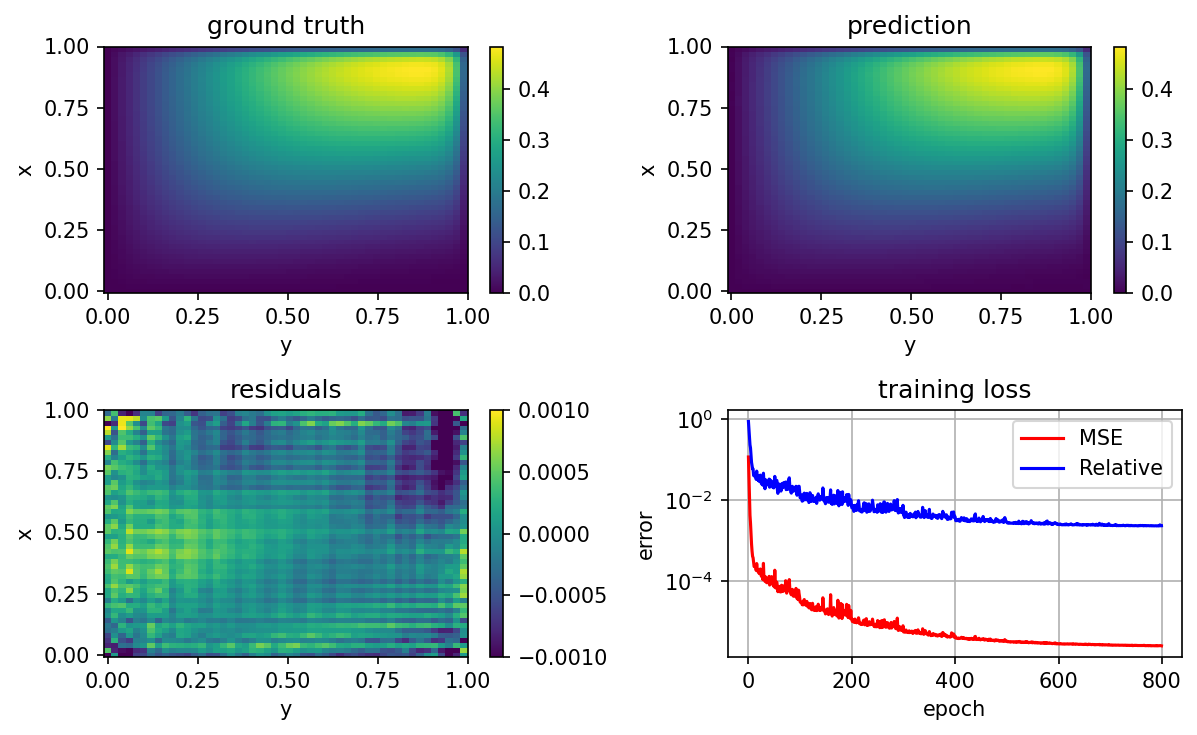

In [19]:
i = 71

X, Y = np.meshgrid(x_grid, y_grid)

residual = pred-y_test
fig = plt.figure(figsize=(8,5),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
plt.pcolormesh(X, Y, y_test[i], shading='auto')
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar()

plt.subplot(2,2,2)
plt.title("prediction")
plt.pcolormesh(X, Y, pred[i], shading='auto')
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar()

plt.subplot(2,2,3)
plt.title("residuals")
plt.pcolormesh(X, Y, residual[i], shading='auto',vmin=-0.001,vmax=0.001)
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

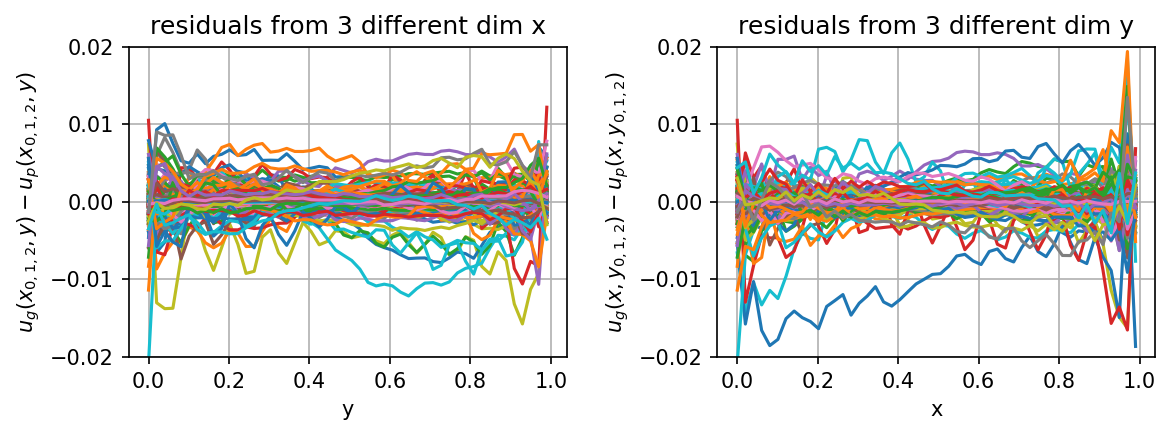

In [6]:
fig_1 = plt.figure(figsize=(8,3),dpi=150)

plt.subplot(1,2,1)
plt.title("residuals from 3 different dim x")
for j in range(ntest):
    for i in range(3):
        plt.plot(x_grid,residual[j,i*x_grid.shape[0]//3])
        plt.ylim((-0.02,0.02))
plt.xlabel("y")
plt.ylabel("$u_g(x_{0,1,2},y)-u_p(x_{0,1,2},y)$")
plt.grid()
        

plt.subplot(1,2,2)
plt.title("residuals from 3 different dim y")
for j in range(ntest):
    for i in range(3):
        plt.plot(x_grid,residual[j,:,i*(x_grid.shape[0]//3)])
        plt.ylim((-0.02,0.02))
plt.xlabel("x")
plt.ylabel("$u_g(x,y_{0,1,2})-u_p(x,y_{0,1,2})$")
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(2.1748e-05) tensor(1.5135e-06)


In [8]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/fno_loss_2d.npy",loss)
torch.save(model,'model/fno_2d')